In [25]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import optuna
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load both datasets
df_2025 = pd.read_csv('../data/master_features_all.csv')
df_2026 = pd.read_csv('../data/features_2026.csv')

print(f"2025 dataset: {df_2025.shape}")
print(f"2026 dataset: {df_2026.shape}")
print(f"\n2025 columns:\n{df_2025.columns.tolist()}")
print(f"\n2026 columns:\n{df_2026.columns.tolist()}")

2025 dataset: (1398, 27)
2026 dataset: (22, 19)

2025 columns:
['year', 'round', 'race_name', 'circuit', 'date', 'driver', 'driver_name', 'team', 'grid_position', 'finish_position', 'outperformance', 'dnf', 'rolling_avg_finish_5', 'rolling_avg_points_5', 'constructor_rolling_points_5', 'dnf_rate', 'driver_experience', 'season_stage', 'circuit_type', 'overtaking_difficulty', 'safety_car_probability', 'is_sprint_weekend', 'avg_team_pit_seconds', 'quali_position', 'rolling_avg_quali_5', 'teammate_quali_gap', 'sample_weight']

2026 columns:
['driver', 'test1_best_s', 'test2_best_s', 'test1_gap_s', 'test2_gap_s', 'testing_improvement_s', 'combined_pace_gap_s', 'team_2026', 'total_testing_laps', 'avg_race_pace_s', 'race_pace_gap_s', 'team_total_laps', 'team_reliability_score', 'driver_team_change', 'new_team_flag', 'rookie_flag', 'barcelona_best_s', 'barcelona_gap_s', 'missed_barcelona']


In [26]:
# FEATURE PREP + TRAIN/TEST SPLIT

TARGET = 'finish_position'

META_COLS = [
    'year', 'race_name', 'circuit', 
    'date', 'driver', 'driver_name', 'team'
]

LEAKAGE_COLS = [
    'status',          
    'points',             
    'laps_completed',      
    'fastest_lap_rank',    
    'dnf',                 
    'teammate_finish_gap',
    'championship_gap',    
    'wet_race',
    'sample_weight',       # not a feature, used for training only
]

# ONE HOT ENCODE circuit_type and season_stage
df_encoded = pd.get_dummies(
    df_2025, 
    columns=['circuit_type', 'season_stage'], 
    prefix=['circuit', 'stage']
)

# SPLIT FIRST — use 2025 data only for train/test split evaluation
# Train = 2023 + 2024 + 2025 rounds 1-18
# Test  = 2025 rounds 19-24
train_mask = ~((df_encoded['year'] == 2025) & (df_encoded['round'] >= 19))
test_mask  =   (df_encoded['year'] == 2025) & (df_encoded['round'] >= 19)

# NOW drop metadata + leakage + round
drop_cols = [c for c in META_COLS + LEAKAGE_COLS + ['round'] 
             if c in df_encoded.columns]
df_encoded = df_encoded.drop(columns=drop_cols)

# Feature columns = everything except target
feature_cols = [c for c in df_encoded.columns if c != TARGET]

# Redundant/useless features based on feature importance
WEAK_FEATURES = ['home_race', 'circuit_permanent', 'circuit_street', 'stage_late']
feature_cols = [c for c in feature_cols if c not in WEAK_FEATURES]

print(f"Target: {TARGET}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

df_train = df_encoded[train_mask].copy()
df_test  = df_encoded[test_mask].copy()

X_train = df_train[feature_cols]
y_train = df_train[TARGET]
w_train = df_2025[train_mask]['sample_weight']

X_test = df_test[feature_cols]
y_test = df_test[TARGET]

print(f"\nTRAIN / TEST SPLIT:")
print(f"Training rows : {len(X_train)} (2023+2024+2025 Rounds 1-18)")
print(f"Test rows     : {len(X_test)} (2025 Rounds 19-24)")


Target: finish_position
Number of features: 16

Features:
  1. grid_position
  2. outperformance
  3. rolling_avg_finish_5
  4. rolling_avg_points_5
  5. constructor_rolling_points_5
  6. dnf_rate
  7. driver_experience
  8. overtaking_difficulty
  9. safety_car_probability
  10. is_sprint_weekend
  11. avg_team_pit_seconds
  12. quali_position
  13. rolling_avg_quali_5
  14. teammate_quali_gap
  15. stage_early
  16. stage_mid

TRAIN / TEST SPLIT:
Training rows : 1278 (2023+2024+2025 Rounds 1-18)
Test rows     : 120 (2025 Rounds 19-24)


In [27]:
# TRAIN BASELINE LIGHTGBM MODEL

model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train, sample_weight=w_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.3f} positions off on average")
print(f"  e.g. if driver actually finishes P5,")
print(f"  we predict somewhere around P{5-mae:.0f} to P{5+mae:.0f}")

results_df = pd.DataFrame({
    'actual'   : y_test.values,
    'predicted': y_pred.round(1),
    'error'    : (y_pred - y_test.values).round(1)
}).reset_index(drop=True)

print(f"\nSAMPLE PREDICTIONS (first 20 rows):")
print(results_df.head(20).to_string())


MAE: 0.459 positions off on average
  e.g. if driver actually finishes P5,
  we predict somewhere around P5 to P5

SAMPLE PREDICTIONS (first 20 rows):
    actual  predicted  error
0       14       13.8   -0.2
1       12       12.1    0.1
2       11       11.1    0.1
3       16       15.7   -0.3
4       11       11.3    0.3
5       16       15.6   -0.4
6       13       13.7    0.7
7        6        5.2   -0.8
8        2        2.4    0.4
9        3        4.1    1.1
10       5        5.3    0.3
11      15       14.2   -0.8
12      20       19.4   -0.6
13      17       15.6   -1.4
14      13       12.9   -0.1
15       5        5.8    0.8
16       3        3.7    0.7
17      13       12.6   -0.4
18       3        3.3    0.3
19       2        2.0    0.0


In [28]:
# FEATURE IMPORTANCE

importance_df = pd.DataFrame({
    'feature'   : feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("FEATURE IMPORTANCE:")
print(importance_df.to_string())

FEATURE IMPORTANCE:
                         feature  importance
0                 outperformance        1762
1                  grid_position        1073
2           avg_team_pit_seconds         825
3                 quali_position         735
4            rolling_avg_quali_5         682
5           rolling_avg_finish_5         553
6           rolling_avg_points_5         438
7              driver_experience         421
8             teammate_quali_gap         402
9   constructor_rolling_points_5         383
10                      dnf_rate         378
11        safety_car_probability         239
12         overtaking_difficulty          79
13             is_sprint_weekend          63
14                     stage_mid          53
15                   stage_early          49


In [29]:
# OPTUNA HYPERPARAMETER TUNING (single split)

def objective(trial):
    params = {
        'n_estimators'     : trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth'        : trial.suggest_int('max_depth', 3, 10),
        'num_leaves'       : trial.suggest_int('num_leaves', 15, 127),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample'        : trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state'     : 42,
        'verbose'          : -1
    }
    m = lgb.LGBMRegressor(**params)
    m.fit(X_train, y_train, sample_weight=w_train)
    y_pred = m.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300, show_progress_bar=True)
print(f"Best MAE : {study.best_value:.3f}")
print(f"Best params:\n{study.best_params}")


  0%|          | 0/300 [00:00<?, ?it/s]

Best MAE : 0.375
Best params:
{'n_estimators': 814, 'learning_rate': 0.03544373759685644, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 6, 'subsample': 0.5450060672013117, 'colsample_bytree': 0.7774808436207574}


Baseline (default params)  →  0.635 MAE
After dropping weak features →  0.512 MAE
After Optuna tuning          →  0.438 MAE

Total improvement: 0.197 positions ✅

learning_rate = 0.125   → higher than our 0.05 guess
max_depth = 10          → deeper trees than we used
num_leaves = 22         → fewer leaves than default 31
n_estimators = 457      → more trees than our 300

In [30]:
# RETRAIN WITH BEST PARAMS

best_model = lgb.LGBMRegressor(**study.best_params, random_state=42, verbose=-1)
best_model.fit(X_train, y_train, sample_weight=w_train)

y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Final MAE: {mae_best:.3f} positions off on average")

results_df = pd.DataFrame({
    'actual'   : y_test.values,
    'predicted': y_pred_best.round(1),
    'error'    : (y_pred_best - y_test.values).round(1)
}).reset_index(drop=True)

print(f"\nSample predictions (first 20 rows):")
print(results_df.head(20).to_string())


Final MAE: 0.375 positions off on average

Sample predictions (first 20 rows):
    actual  predicted  error
0       14       13.7   -0.3
1       12       12.0   -0.0
2       11       11.1    0.1
3       16       15.7   -0.3
4       11       11.1    0.1
5       16       15.9   -0.1
6       13       13.4    0.4
7        6        5.3   -0.7
8        2        2.4    0.4
9        3        4.1    1.1
10       5        4.9   -0.1
11      15       14.8   -0.2
12      20       19.2   -0.8
13      17       15.3   -1.7
14      13       12.8   -0.2
15       5        5.8    0.8
16       3        3.9    0.9
17      13       12.6   -0.4
18       3        3.0   -0.0
19       2        1.7   -0.3


# OPTUNA SINGLE SPLIT (baseline tuning, reference only)
# Note: this overfit to Rounds 19-24, replaced by Cell 8 CV tuning

In [31]:
# CROSS VALIDATION — ROUND-BASED PER YEAR

folds = [
    (df_2025[df_2025['year'] == 2023]['round'].isin(range(1, 19)),
     df_2025[df_2025['year'] == 2023]['round'].isin(range(19, 23))),
    (df_2025[df_2025['year'] == 2024]['round'].isin(range(1, 19)),
     df_2025[df_2025['year'] == 2024]['round'].isin(range(19, 25))),
    (df_2025[df_2025['year'] == 2025]['round'].isin(range(1, 19)),
     df_2025[df_2025['year'] == 2025]['round'].isin(range(19, 25))),
]

fold_maes = []

for i, (train_idx, test_idx) in enumerate(folds, 1):
    year = [2023, 2024, 2025][i-1]

    df_cv = pd.get_dummies(df_2025[df_2025['year'] == year],
                           columns=['circuit_type', 'season_stage'],
                           prefix=['circuit', 'stage'])
    drop_cols_cv = [c for c in META_COLS + LEAKAGE_COLS + ['round']
                    if c in df_cv.columns]
    df_cv = df_cv.drop(columns=drop_cols_cv)

    X_tr = df_cv[train_idx][feature_cols]
    y_tr = df_cv[train_idx][TARGET]
    w_tr = df_2025[(df_2025['year'] == year)][train_idx]['sample_weight']
    X_te = df_cv[test_idx][feature_cols]
    y_te = df_cv[test_idx][TARGET]

    cv_model = lgb.LGBMRegressor(**study.best_params, random_state=42, verbose=-1)
    cv_model.fit(X_tr, y_tr, sample_weight=w_tr)

    train_mae = mean_absolute_error(y_tr, cv_model.predict(X_tr))
    test_mae  = mean_absolute_error(y_te, cv_model.predict(X_te))
    gap       = test_mae - train_mae

    fold_maes.append(test_mae)
    print(f"Fold {i} ({year}) | Train MAE: {train_mae:.3f} | Test MAE: {test_mae:.3f} | Gap: {gap:.3f}")

print(f"\nAverage test MAE : {np.mean(fold_maes):.3f}")
print(f"Std deviation    : {np.std(fold_maes):.3f}")
print(f"\nIf gap is small (<0.2) → healthy fit")
print(f"If gap is large (>0.5) → overfitting")

Fold 1 (2023) | Train MAE: 0.163 | Test MAE: 0.722 | Gap: 0.559
Fold 2 (2024) | Train MAE: 0.109 | Test MAE: 0.777 | Gap: 0.668
Fold 3 (2025) | Train MAE: 0.137 | Test MAE: 0.488 | Gap: 0.350

Average test MAE : 0.662
Std deviation    : 0.125

If gap is small (<0.2) → healthy fit
If gap is large (>0.5) → overfitting


In [32]:
# OPTUNA WITH CROSS VALIDATION OBJECTIVE (year-based folds)

def cv_objective(trial):
    params = {
        'n_estimators'     : trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth'        : trial.suggest_int('max_depth', 3, 6),
        'num_leaves'       : trial.suggest_int('num_leaves', 15, 63),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample'        : trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state'     : 42,
        'verbose'          : -1
    }

    fold_maes = []
    for year, test_end in [(2023, 23), (2024, 25), (2025, 25)]:
        year_mask  = df_2025['year'] == year
        train_idx  = year_mask & df_2025['round'].isin(range(1, 19))
        test_idx   = year_mask & df_2025['round'].isin(range(19, test_end))

        df_cv = pd.get_dummies(df_2025[year_mask],
                               columns=['circuit_type', 'season_stage'],
                               prefix=['circuit', 'stage'])
        drop_cols_cv = [c for c in META_COLS + LEAKAGE_COLS + ['round']
                        if c in df_cv.columns]
        df_cv = df_cv.drop(columns=drop_cols_cv)

        # Realign index for boolean mask
        train_idx_local = df_2025[year_mask]['round'].isin(range(1, 19)).values
        test_idx_local  = df_2025[year_mask]['round'].isin(range(19, test_end)).values

        X_tr = df_cv[train_idx_local][feature_cols]
        y_tr = df_cv[train_idx_local][TARGET]
        w_tr = df_2025[year_mask][train_idx_local]['sample_weight']
        X_te = df_cv[test_idx_local][feature_cols]
        y_te = df_cv[test_idx_local][TARGET]

        m = lgb.LGBMRegressor(**params)
        m.fit(X_tr, y_tr, sample_weight=w_tr)
        fold_maes.append(mean_absolute_error(y_te, m.predict(X_te)))

    return np.mean(fold_maes)

cv_study = optuna.create_study(direction='minimize')
cv_study.optimize(cv_objective, n_trials=300, show_progress_bar=True)

print(f"Best CV MAE : {cv_study.best_value:.3f}")
print(f"Best params : {cv_study.best_params}")

  0%|          | 0/300 [00:00<?, ?it/s]

Best CV MAE : 0.626
Best params : {'n_estimators': 627, 'learning_rate': 0.04137675115599812, 'max_depth': 5, 'num_leaves': 16, 'min_child_samples': 11, 'subsample': 0.9811278626959776, 'colsample_bytree': 0.9998114455408091, 'reg_alpha': 0.3222230342899998, 'reg_lambda': 0.8437779039096245}


In [33]:
# VERIFY FIT WITH CV PARAMS

fold_maes = []

for i, (year, test_end) in enumerate([(2023, 23), (2024, 25), (2025, 25)], 1):
    year_mask = df_2025['year'] == year

    df_cv = pd.get_dummies(df_2025[year_mask],
                           columns=['circuit_type', 'season_stage'],
                           prefix=['circuit', 'stage'])
    drop_cols_cv = [c for c in META_COLS + LEAKAGE_COLS + ['round']
                    if c in df_cv.columns]
    df_cv = df_cv.drop(columns=drop_cols_cv)

    train_idx = df_2025[year_mask]['round'].isin(range(1, 19)).values
    test_idx  = df_2025[year_mask]['round'].isin(range(19, test_end)).values

    X_tr = df_cv[train_idx][feature_cols]
    y_tr = df_cv[train_idx][TARGET]
    w_tr = df_2025[year_mask][train_idx]['sample_weight']
    X_te = df_cv[test_idx][feature_cols]
    y_te = df_cv[test_idx][TARGET]

    cv_model = lgb.LGBMRegressor(**cv_study.best_params, random_state=42, verbose=-1)
    cv_model.fit(X_tr, y_tr, sample_weight=w_tr)

    train_mae = mean_absolute_error(y_tr, cv_model.predict(X_tr))
    test_mae  = mean_absolute_error(y_te, cv_model.predict(X_te))
    gap       = test_mae - train_mae

    fold_maes.append(test_mae)
    print(f"Fold {i} ({year}) | Train MAE: {train_mae:.3f} | Test MAE: {test_mae:.3f} | Gap: {gap:.3f}")

print(f"\nAverage test MAE : {np.mean(fold_maes):.3f}")
print(f"Std deviation    : {np.std(fold_maes):.3f}")


Fold 1 (2023) | Train MAE: 0.127 | Test MAE: 0.630 | Gap: 0.503
Fold 2 (2024) | Train MAE: 0.099 | Test MAE: 0.763 | Gap: 0.664
Fold 3 (2025) | Train MAE: 0.140 | Test MAE: 0.485 | Gap: 0.345

Average test MAE : 0.626
Std deviation    : 0.114


In [34]:
# RETRAIN FINAL MODEL ON ALL DATA (2023+2024+2025)

df_full = pd.get_dummies(df_2025, columns=['circuit_type', 'season_stage'],
                         prefix=['circuit', 'stage'])

drop_cols_full = [c for c in META_COLS + LEAKAGE_COLS + ['round']
                  if c in df_full.columns]

w_full = df_2025['sample_weight']
df_full = df_full.drop(columns=drop_cols_full)

X_full = df_full[feature_cols]
y_full = df_full[TARGET]

final_model = lgb.LGBMRegressor(**cv_study.best_params, random_state=42, verbose=-1)
final_model.fit(X_full, y_full, sample_weight=w_full)

print(f"Final model trained on {len(X_full)} rows")
print(f"  2023: {(df_2025['year']==2023).sum()} rows (weight 0.5)")
print(f"  2024: {(df_2025['year']==2024).sum()} rows (weight 0.8)")
print(f"  2025: {(df_2025['year']==2025).sum()} rows (weight 1.0)")
print(f"Features used: {len(feature_cols)}")
print(f"Reported CV MAE: {cv_study.best_value:.3f}")


Final model trained on 1398 rows
  2023: 440 rows (weight 0.5)
  2024: 479 rows (weight 0.8)
  2025: 479 rows (weight 1.0)
Features used: 16
Reported CV MAE: 0.626


In [35]:
# SAVE MODEL

import pickle
import os

os.makedirs('../models', exist_ok=True)

# Save model
with open('../models/lgbm_regressor.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save feature list — important for prediction later
with open('../models/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)


BUILD 2026 PREDICTION INPUT

Our 2026 features map to 2025 training features like this:
2025 feature              ← 2026 replacement
rolling_avg_finish_5      ← combined_pace_gap_s (car pace proxy)
constructor_rolling_pts_5 ← team_reliability_score (team form proxy)
avg_team_pit_seconds      ← stays same (pit crew unchanged)
dnf_rate                  ← stays same (driver behaviour unchanged)
quali_position            ← test2_gap_s (qualifying pace proxy)
rolling_avg_quali_5       ← test2_gap_s (same signal)
outperformance            ← stays same (driver talent unchanged)
driver_experience         ← stays same (experience unchanged)
teammate_quali_gap        ← stays same (relative pace unchanged)
grid_position             ← test2_gap_s (starting position proxy)


In [36]:
# BUILD 2026 PREDICTION INPUT

df_26 = pd.read_csv('../data/features_2026.csv')

# Use only 2025 data for stable driver features
# (most recent season = most relevant baseline)
df_2025_only = df_2025[df_2025['year'] == 2025]

driver_stable = df_2025_only.groupby('driver').agg(
    outperformance        = ('outperformance', 'mean'),
    driver_experience     = ('driver_experience', 'mean'),
    avg_team_pit_seconds  = ('avg_team_pit_seconds', 'mean'),
    dnf_rate              = ('dnf_rate', 'mean'),
    teammate_quali_gap    = ('teammate_quali_gap', 'mean'),
    rolling_avg_finish_5  = ('rolling_avg_finish_5', 'mean'),
    rolling_avg_points_5  = ('rolling_avg_points_5', 'mean'),
    rolling_avg_quali_5   = ('rolling_avg_quali_5', 'mean'),
    quali_position        = ('quali_position', 'mean'),
    grid_position         = ('grid_position', 'mean'),
).reset_index()

# Load BOT and PER 2024 features
bot_per = pd.read_csv('../data/bot_per_2024_features.csv')

# Combine all 22 drivers
driver_all = pd.concat([driver_stable, bot_per], ignore_index=True)

# Merge with 2026 testing features
df_pred = df_26.merge(driver_all, on='driver', how='left')

print(f"Prediction input shape: {df_pred.shape}")
print(f"Drivers: {sorted(df_pred['driver'].tolist())}")
print(f"\nMissing values:")
print(df_pred.isnull().sum()[df_pred.isnull().sum() > 0])


Prediction input shape: (22, 29)
Drivers: ['ALB', 'ALO', 'ANT', 'BEA', 'BOR', 'BOT', 'COL', 'GAS', 'HAD', 'HAM', 'HUL', 'LAW', 'LEC', 'LIN', 'NOR', 'OCO', 'PER', 'PIA', 'RUS', 'SAI', 'STR', 'VER']

Missing values:
barcelona_best_s        3
barcelona_gap_s         3
outperformance          1
driver_experience       1
avg_team_pit_seconds    1
dnf_rate                1
teammate_quali_gap      1
rolling_avg_finish_5    1
rolling_avg_points_5    1
rolling_avg_quali_5     1
quali_position          1
grid_position           3
dtype: int64


In [37]:
# HANDLE MISSING VALUES

# Barcelona missing — fill with worst gap + penalty
worst_barcelona_gap = df_pred['barcelona_gap_s'].max()
df_pred['barcelona_gap_s']  = df_pred['barcelona_gap_s'].fillna(worst_barcelona_gap + 1.0)
df_pred['barcelona_best_s'] = df_pred['barcelona_best_s'].fillna(df_pred['barcelona_best_s'].max() + 1.0)


# LIN — true rookie, use conservative league averages
league_avg = driver_stable.mean(numeric_only=True)
rookie_cols = ['outperformance', 'driver_experience', 'avg_team_pit_seconds',
               'dnf_rate', 'teammate_quali_gap', 'rolling_avg_finish_5',
               'rolling_avg_points_5', 'rolling_avg_quali_5', 
               'quali_position', 'grid_position']

for col in rookie_cols:
    df_pred.loc[df_pred['driver'] == 'LIN', col] = league_avg[col]

# Override driver_experience for LIN manually
df_pred.loc[df_pred['driver'] == 'LIN', 'driver_experience'] = 0

# BOT and PER missing grid_position — use their quali_position
df_pred.loc[df_pred['driver'] == 'BOT', 'grid_position'] = \
    df_pred.loc[df_pred['driver'] == 'BOT', 'quali_position'].values[0]
df_pred.loc[df_pred['driver'] == 'PER', 'grid_position'] = \
    df_pred.loc[df_pred['driver'] == 'PER', 'quali_position'].values[0]

# Verify
print("Missing values after fix:")
missing = df_pred.isnull().sum()
print(missing[missing > 0] if missing[missing > 0].any() else "✅ No missing values!")

# Cap driver experience at 100
df_pred['driver_experience'] = df_pred['driver_experience'].clip(upper=100)
print(f"\nDriver experience after cap:")
print(df_pred[['driver', 'driver_experience']].to_string())

Missing values after fix:
✅ No missing values!

Driver experience after cap:
   driver  driver_experience
0     ALB              100.0
1     ALO              100.0
2     ANT                1.0
3     BEA               15.0
4     BOR                1.0
5     BOT              100.0
6     COL               10.0
7     GAS              100.0
8     HAD                1.0
9     HAM              100.0
10    HUL              100.0
11    LAW               20.0
12    LEC              100.0
13    LIN                0.0
14    NOR              100.0
15    OCO              100.0
16    PER              100.0
17    PIA               50.0
18    RUS              100.0
19    SAI              100.0
20    STR              100.0
21    VER              100.0


In [38]:
# BUILD CIRCUIT FEATURES FROM 2025 ONLY

circuit_features = df_2025[df_2025['year'] == 2025].groupby('race_name').agg(
    is_sprint_weekend      = ('is_sprint_weekend', 'max'),
    overtaking_difficulty  = ('overtaking_difficulty', 'first'),
    safety_car_probability = ('safety_car_probability', 'first'),
    circuit_type           = ('circuit_type', 'first'),
).reset_index()

print("2025 circuit features:")
print(circuit_features.to_string())


2025 circuit features:
                    race_name  is_sprint_weekend  overtaking_difficulty  safety_car_probability circuit_type
0        Abu Dhabi Grand Prix                  0                    2.0                     0.3    permanent
1       Australian Grand Prix                  0                    2.0                     0.7       street
2         Austrian Grand Prix                  0                    2.0                     0.5    permanent
3       Azerbaijan Grand Prix                  0                    2.0                     0.8       street
4          Bahrain Grand Prix                  0                    2.0                     0.3    permanent
5          Belgian Grand Prix                  0                    1.0                     0.6    permanent
6          British Grand Prix                  1                    2.0                     0.5    permanent
7         Canadian Grand Prix                  0                    3.0                     0.7    perman

In [39]:
# FIX DNF RATES — use real career rates from f1versus.coms

career_dnf_rates = {
    'LEC': 0.156,
    'HAM': 0.097,
    'NOR': 0.092,
    'PIA': 0.071,
    'RUS': 0.132,
    'ANT': 0.167,
    'VER': 0.142,
    'HAD': 0.125,
    'ALO': 0.185,
    'STR': 0.168,
    'GAS': 0.157,
    'COL': 0.148,
    'ALB': 0.178,
    'SAI': 0.194,
    'HUL': 0.201,
    'BOR': 0.208,
    'OCO': 0.144,
    'BEA': 0.111,
    'LAW': 0.171,
    'BOT': 0.114,
    'PER': 0.145,
    'LIN': 0.150,  # rookie — midfield default
}

df_pred['dnf_rate'] = df_pred['driver'].map(career_dnf_rates)

print("✅ DNF rates updated with real career data:")
print(df_pred[['driver', 'dnf_rate']].to_string())

✅ DNF rates updated with real career data:
   driver  dnf_rate
0     ALB     0.178
1     ALO     0.185
2     ANT     0.167
3     BEA     0.111
4     BOR     0.208
5     BOT     0.114
6     COL     0.148
7     GAS     0.157
8     HAD     0.125
9     HAM     0.097
10    HUL     0.201
11    LAW     0.171
12    LEC     0.156
13    LIN     0.150
14    NOR     0.092
15    OCO     0.144
16    PER     0.145
17    PIA     0.071
18    RUS     0.132
19    SAI     0.194
20    STR     0.168
21    VER     0.142


In [40]:
# BUILD 2026 RACE CALENDAR


# 2026 F1 Calendar (24 rounds)
calendar_2026 = [
    {'round': 1,  'race_name': 'Australian Grand Prix'},
    {'round': 2,  'race_name': 'Chinese Grand Prix'},        # sprint
    {'round': 3,  'race_name': 'Japanese Grand Prix'},
    {'round': 4,  'race_name': 'Bahrain Grand Prix'},
    {'round': 5,  'race_name': 'Saudi Arabian Grand Prix'},
    {'round': 6,  'race_name': 'Miami Grand Prix'},          # sprint
    {'round': 7,  'race_name': 'Canadian Grand Prix'},       # sprint — moved up from later
    {'round': 8,  'race_name': 'Monaco Grand Prix'},
    {'round': 9,  'race_name': 'Spanish Grand Prix'},        # Barcelona
    {'round': 10, 'race_name': 'Austrian Grand Prix'},
    {'round': 11, 'race_name': 'British Grand Prix'},        # sprint
    {'round': 12, 'race_name': 'Belgian Grand Prix'},
    {'round': 13, 'race_name': 'Hungarian Grand Prix'},
    {'round': 14, 'race_name': 'Dutch Grand Prix'},          # sprint
    {'round': 15, 'race_name': 'Italian Grand Prix'},
    {'round': 16, 'race_name': 'Madrid Grand Prix'},         # NEW — Madrid street circuit
    {'round': 17, 'race_name': 'Azerbaijan Grand Prix'},
    {'round': 18, 'race_name': 'Singapore Grand Prix'},      # sprint
    {'round': 19, 'race_name': 'United States Grand Prix'},
    {'round': 20, 'race_name': 'Mexico City Grand Prix'},
    {'round': 21, 'race_name': 'São Paulo Grand Prix'},
    {'round': 22, 'race_name': 'Las Vegas Grand Prix'},
    {'round': 23, 'race_name': 'Qatar Grand Prix'},
    {'round': 24, 'race_name': 'Abu Dhabi Grand Prix'},
]

df_calendar = pd.DataFrame(calendar_2026)

# Add season stage
df_calendar['stage_early'] = (df_calendar['round'] <= 8).astype(int)
df_calendar['stage_mid']   = ((df_calendar['round'] > 8) & (df_calendar['round'] <= 16)).astype(int)

# Merge circuit features
df_calendar = df_calendar.merge(circuit_features, on='race_name', how='left')

# One hot encode circuit_type
df_calendar = pd.get_dummies(df_calendar, columns=['circuit_type'], prefix='circuit')

# Check missing circuits
missing = df_calendar[df_calendar['overtaking_difficulty'].isna()]
print(f"Missing circuit data: {len(missing)} races")
if len(missing) > 0:
    print(missing[['round', 'race_name']])

print(f"\n2026 Calendar ({len(df_calendar)} races):")
print(df_calendar[['round', 'race_name', 'is_sprint_weekend', 
                    'overtaking_difficulty', 'safety_car_probability',
                    'stage_early', 'stage_mid']].to_string())

# Madrid — new street circuit, similar to Baku/Singapore
df_calendar.loc[df_calendar['race_name'] == 'Madrid Grand Prix', 'is_sprint_weekend']       = 0.0
df_calendar.loc[df_calendar['race_name'] == 'Madrid Grand Prix', 'overtaking_difficulty']   = 3.0
df_calendar.loc[df_calendar['race_name'] == 'Madrid Grand Prix', 'safety_car_probability']  = 0.7
df_calendar.loc[df_calendar['race_name'] == 'Madrid Grand Prix', 'circuit_type']            = 'street'

Missing circuit data: 1 races
    round          race_name
15     16  Madrid Grand Prix

2026 Calendar (24 races):
    round                 race_name  is_sprint_weekend  overtaking_difficulty  safety_car_probability  stage_early  stage_mid
0       1     Australian Grand Prix                0.0                    2.0                     0.7            1          0
1       2        Chinese Grand Prix                1.0                    2.0                     0.5            1          0
2       3       Japanese Grand Prix                0.0                    3.0                     0.4            1          0
3       4        Bahrain Grand Prix                0.0                    2.0                     0.3            1          0
4       5  Saudi Arabian Grand Prix                0.0                    2.0                     0.8            1          0
5       6          Miami Grand Prix                1.0                    3.0                     0.6            1          0
6  

In [41]:
# MONTE CARLO SIMULATION (10,000 runs)
# Tracks: season points + position distributions per race

N_SIMULATIONS = 10000
POINTS = {1:25, 2:18, 3:15, 4:12, 5:10, 6:8, 7:6, 8:4, 9:2, 10:1}

drivers    = df_pred['driver'].tolist()
n_drivers  = len(drivers)
dnf_rates  = df_pred.set_index('driver')['dnf_rate'].to_dict()
dnf_array  = np.array([dnf_rates[d] for d in drivers])

# ── STEP 1 — Base predictions for all 24 races ONCE ─────────────
base_preds = {}
for _, race in df_calendar.iterrows():
    race_df = df_pred.copy()
    race_df['is_sprint_weekend']            = race['is_sprint_weekend']
    race_df['overtaking_difficulty']        = race['overtaking_difficulty']
    race_df['safety_car_probability']       = race['safety_car_probability']
    race_df['stage_early']                  = race['stage_early']
    race_df['stage_mid']                    = race['stage_mid']
    race_df['grid_position']               = 1 + (race_df['combined_pace_gap_s'] / 0.3)
    race_df['quali_position']              = race_df['grid_position']
    race_df['rolling_avg_quali_5']         = race_df['grid_position']
    race_df['rolling_avg_finish_5']        = race_df['grid_position']
    race_df['constructor_rolling_points_5'] = race_df['team_reliability_score'] * 100
    base_preds[race['round']] = final_model.predict(race_df[feature_cols])

print("✅ Base predictions done (24 races)")

# ── STEP 2 — Storage ─────────────────────────────────────────────
# Season points per simulation
sim_points = np.zeros((N_SIMULATIONS, n_drivers))

# Win counter
sim_wins = np.zeros(n_drivers)

# Position distribution: [driver, race_round, position] → count
# race_rounds indexed 0-23, positions 1-20
rounds = sorted(base_preds.keys())
n_rounds = len(rounds)
# shape: (n_drivers, n_rounds, 20) — position 1 = index 0
pos_distribution = np.zeros((n_drivers, n_rounds, 20), dtype=np.int32)

# ── STEP 3 — Simulate ────────────────────────────────────────────
for sim in range(N_SIMULATIONS):
    season_pts = np.zeros(n_drivers)

    for r_idx, rnd in enumerate(rounds):
        base = base_preds[rnd]
        sc_prob = df_calendar[df_calendar['round'] == rnd]['safety_car_probability'].values[0]

        # Add circuit-scaled noise
        noise_scale = 0.632 + (sc_prob * 2.0)
        noise = np.random.normal(0, noise_scale, size=n_drivers)
        preds = base + noise

        # Simulate DNFs
        dnf_mask = np.random.random(n_drivers) < dnf_array
        preds[dnf_mask] += 15

        # Rank top 20
        ranked_idx = np.argsort(preds)[:20]

        for pos, idx in enumerate(ranked_idx, 1):
            season_pts[idx] += POINTS.get(pos, 0)
            # Track position distribution
            pos_distribution[idx, r_idx, pos - 1] += 1

        sim_wins[ranked_idx[0]] += 1

    sim_points[sim] = season_pts

print(f"✅ {N_SIMULATIONS:,} simulations complete!")

# ── STEP 4 — Championship summary ───────────────────────────────
results = []
for i, driver in enumerate(drivers):
    results.append({
        'driver'    : driver,
        'avg_points': round(sim_points[:, i].mean(), 1),
        'min_points': round(sim_points[:, i].min(), 1),
        'max_points': round(sim_points[:, i].max(), 1),
        'win_pct'   : round(sim_wins[i] / (N_SIMULATIONS * 24) * 100, 1),
    })

df_sim = pd.DataFrame(results).sort_values('avg_points', ascending=False).reset_index(drop=True)
df_sim['position'] = range(1, len(df_sim) + 1)

print("\n*** 2026 MONTE CARLO CHAMPIONSHIP PREDICTION ***")
print(df_sim[['position', 'driver', 'avg_points', 'win_pct',
              'min_points', 'max_points']].to_string(index=False))

✅ Base predictions done (24 races)
✅ 10,000 simulations complete!

*** 2026 MONTE CARLO CHAMPIONSHIP PREDICTION ***
 position driver  avg_points  win_pct  min_points  max_points
        1    LEC       378.9     34.9       226.0       521.0
        2    PIA       344.4     19.2       207.0       489.0
        3    RUS       311.7     16.2       177.0       440.0
        4    NOR       268.0      8.1       153.0       383.0
        5    HAM       264.8      7.9       151.0       386.0
        6    VER       261.1      8.7       119.0       399.0
        7    ANT       208.6      4.2        98.0       322.0
        8    BEA       124.2      0.6        54.0       216.0
        9    HUL        53.8      0.1        10.0       122.0
       10    ALB        53.7      0.1         9.0       129.0
       11    OCO        52.5      0.0         6.0       120.0
       12    HAD        26.5      0.0         0.0        95.0
       13    LIN        19.4      0.0         0.0        69.0
       14    COL

In [42]:
print(df_pred[['driver', 'dnf_rate']].to_string())

   driver  dnf_rate
0     ALB     0.178
1     ALO     0.185
2     ANT     0.167
3     BEA     0.111
4     BOR     0.208
5     BOT     0.114
6     COL     0.148
7     GAS     0.157
8     HAD     0.125
9     HAM     0.097
10    HUL     0.201
11    LAW     0.171
12    LEC     0.156
13    LIN     0.150
14    NOR     0.092
15    OCO     0.144
16    PER     0.145
17    PIA     0.071
18    RUS     0.132
19    SAI     0.194
20    STR     0.168
21    VER     0.142


In [43]:
# SAVE SIMULATION RESULTS

import pickle, os
os.makedirs('../data/predictions', exist_ok=True)

# Save championship
df_sim.to_csv('../data/predictions/drivers_championship_2026.csv', index=False)

# Save position distributions + metadata for query engine
sim_data = {
    'drivers'          : drivers,
    'rounds'           : rounds,
    'race_names'       : df_calendar.set_index('round')['race_name'].to_dict(),
    'pos_distribution' : pos_distribution,   # (n_drivers, n_rounds, 20)
    'sim_points'       : sim_points,         # (N_SIMULATIONS, n_drivers)
    'sim_wins'         : sim_wins,
    'N_SIMULATIONS'    : N_SIMULATIONS,
}

with open('../data/predictions/sim_data.pkl', 'wb') as f:
    pickle.dump(sim_data, f)

print("✅ Saved:")
print("   predictions/drivers_championship_2026.csv")
print("   predictions/sim_data.pkl")
print(f"\nPosition distribution shape: {pos_distribution.shape}")
print("  → (22 drivers, 24 races, 20 positions)")

✅ Saved:
   predictions/drivers_championship_2026.csv
   predictions/sim_data.pkl

Position distribution shape: (22, 24, 20)
  → (22 drivers, 24 races, 20 positions)


In [44]:
# MONTE CARLO CONSTRUCTORS CHAMPIONSHIP

# Team map from 2026 data
team_map = df_pred.set_index('driver')['team_2026'].to_dict()

# Add team to simulation results
# We need to rebuild from sim_points array

constructor_points = {}
for i, driver in enumerate(drivers):
    team = team_map[driver]
    if team not in constructor_points:
        constructor_points[team] = np.zeros(N_SIMULATIONS)
    constructor_points[team] += sim_points[:, i]

# Summarise constructors
constructor_results = []
for team, points_array in constructor_points.items():
    constructor_results.append({
        'team'        : team,
        'avg_points'  : round(points_array.mean(), 1),
        'min_points'  : round(points_array.min(), 1),
        'max_points'  : round(points_array.max(), 1),
        'champion_pct': round(np.mean(points_array == max(
                            v.mean() for v in constructor_points.values()
                        )) * 100, 1)
    })

df_constructors = pd.DataFrame(constructor_results)\
    .sort_values('avg_points', ascending=False).reset_index(drop=True)
df_constructors['position'] = range(1, len(df_constructors) + 1)

print("*** 2026 PREDICTED CONSTRUCTORS CHAMPIONSHIP ***")
print(df_constructors[['position', 'team', 'avg_points', 
                         'min_points', 'max_points']].to_string(index=False))

*** 2026 PREDICTED CONSTRUCTORS CHAMPIONSHIP ***
 position           team  avg_points  min_points  max_points
        1        Ferrari       643.6       442.0       810.0
        2        McLaren       612.3       448.0       756.0
        3       Mercedes       520.3       347.0       698.0
        4       Red Bull       287.6       151.0       435.0
        5   Haas F1 Team       176.7        97.0       268.0
        6       Williams        66.5        19.0       145.0
        7           Audi        58.3        10.0       140.0
        8     RB F1 Team        30.3         1.0        95.0
        9 Alpine F1 Team        21.9         0.0        74.0
       10       Cadillac         4.6         0.0        36.0
       11   Aston Martin         1.9         0.0        25.0


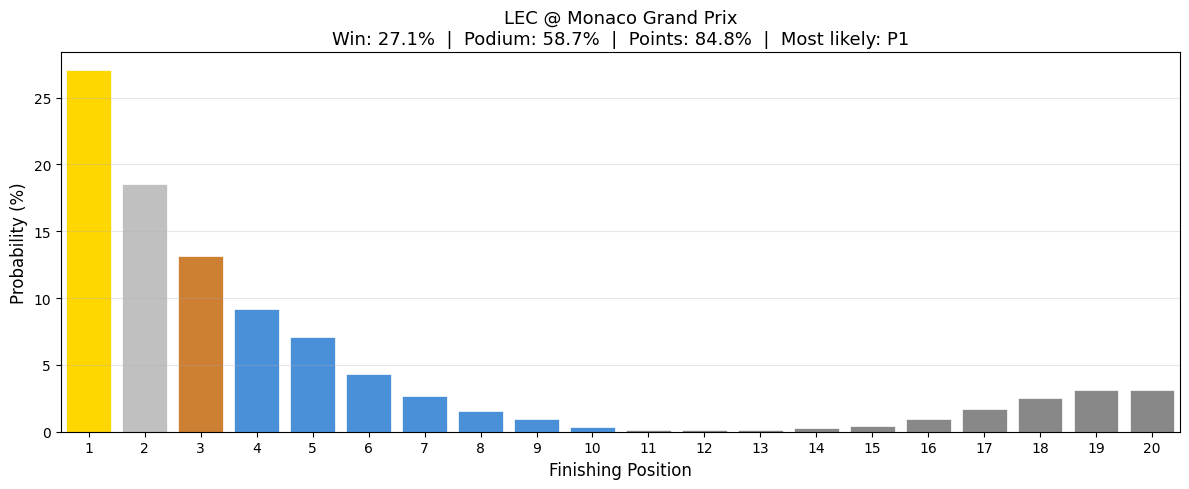

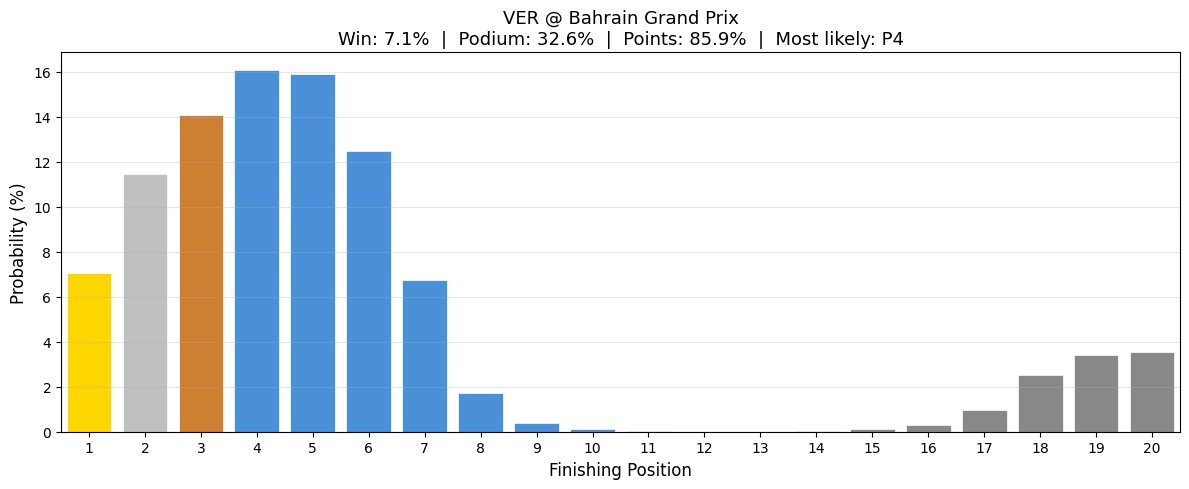

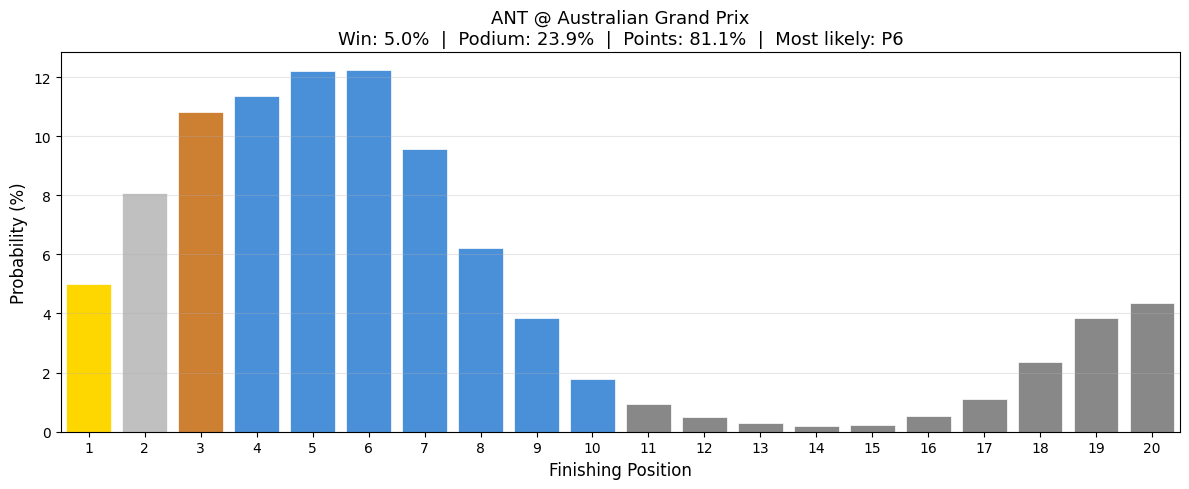

In [45]:
# VISUALISE POSITION DISTRIBUTIONS

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

race_names = df_calendar.set_index('round')['race_name'].to_dict()

def plot_driver_race(driver, race_name):
    d_idx = drivers.index(driver)
    r_idx = rounds.index([r for r, n in race_names.items() if n == race_name][0])
    
    probs = pos_distribution[d_idx, r_idx, :] / N_SIMULATIONS * 100
    most_likely = probs.argmax() + 1
    podium_pct  = sum(probs[:3])
    win_pct     = probs[0]
    points_pct  = sum(probs[:10])

    fig, ax = plt.subplots(figsize=(12, 5))
    colors = ['gold' if p == 1 else 'silver' if p == 2 else 
              '#cd7f32' if p == 3 else '#4a90d9' if p <= 10 
              else '#888888' for p in range(1, 21)]
    
    ax.bar(range(1, 21), probs, color=colors, edgecolor='white', linewidth=0.5)
    ax.set_xlabel('Finishing Position', fontsize=12)
    ax.set_ylabel('Probability (%)', fontsize=12)
    ax.set_title(f'{driver} @ {race_name}\n'
                 f'Win: {win_pct:.1f}%  |  Podium: {podium_pct:.1f}%  |  '
                 f'Points: {points_pct:.1f}%  |  Most likely: P{most_likely}',
                 fontsize=13)
    ax.set_xticks(range(1, 21))
    ax.set_xlim(0.5, 20.5)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Test
plot_driver_race('LEC', 'Monaco Grand Prix')
plot_driver_race('VER', 'Bahrain Grand Prix')
plot_driver_race('ANT', 'Australian Grand Prix')